## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout


"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)

            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [32, 128, 256]
MOMENTUM = 0.95
DROP_RATE = 0.25

Experiment with batch = 32.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)  

Epoch 49/50
50000/50000 [==============================] - 23s 469us/step - loss: 0.8015 - acc: 0.7161 - val_loss: 1.5847 - val_acc: 0.5000
Epoch 50/50
50000/50000 [==============================] - 23s 469us/step - loss: 0.7899 - acc: 0.7170 - val_loss: 1.6006 - val_acc: 0.5039
Experiment with batch = 128.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Ba

50000/50000 [==============================] - 7s 150us/step - loss: 0.2932 - acc: 0.9000 - val_loss: 2.5594 - val_acc: 0.4488
Epoch 48/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.2849 - acc: 0.9040 - val_loss: 2.4800 - val_acc: 0.4541
Epoch 49/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.2793 - acc: 0.9037 - val_loss: 2.4394 - val_acc: 0.4640
Epoch 50/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.2756 - acc: 0.9059 - val_loss: 2.5628 - val_acc: 0.4630
Experiment with batch = 256.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Ba

Epoch 46/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.2093 - acc: 0.9410 - val_loss: 2.3849 - val_acc: 0.4716
Epoch 47/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.2004 - acc: 0.9436 - val_loss: 2.3383 - val_acc: 0.4822
Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.1859 - acc: 0.9502 - val_loss: 2.4899 - val_acc: 0.4652
Epoch 49/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.1752 - acc: 0.9536 - val_loss: 2.3333 - val_acc: 0.4818
Epoch 50/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.1699 - acc: 0.9539 - val_loss: 2.4154 - val_acc: 0.4768


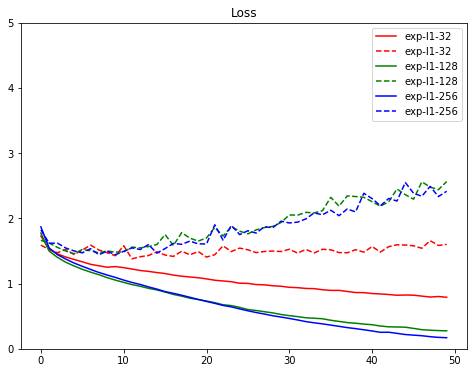

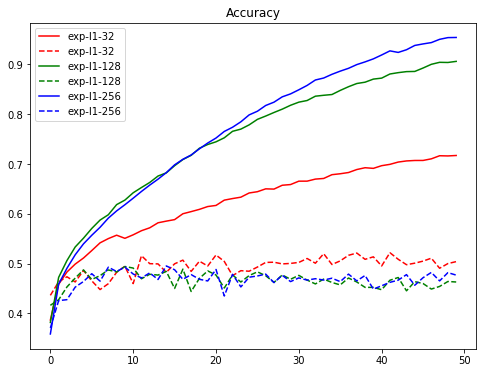

In [9]:
results = {}
"""
使用迴圈建立不同的帶不同L1的模型並訓練
"""
for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch = %.6f" % (batch))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizers = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizers)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(batch)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()